## **Друга модель**

Сформулюємо завдання

In [83]:
# Для початку сформулюємо нашу задачу за допомогою функції LaTeX
from IPython.display import display, Math

# Створення текстового представлення умови задачі у вигляді LaTeX
task_description = r"""
\textbf{Знайти чисельний розв'язок рівняння:}
$$
\frac{\partial^2 S}{\partial \xi^2} + \frac{\partial^2 S}{\partial \eta^2} + \xi \frac{\partial S}{\partial \xi} - \eta \frac{\partial S}{\partial \eta} = 0, \quad (\xi; \eta) \in [-2; 2] \times [0; 4].
$$

\textbf{Система координат:}
$$
\frac{x}{\alpha} = \frac{1}{2} (\eta^2 - \xi^2), \quad \frac{y}{\sqrt{\alpha \beta}} = \xi \eta, \quad \alpha = 3, \, \beta = 4.
$$

\textbf{Граничні умови:}
1. $$S(-2; \eta) = 1, \, \eta \in [2; 4], \quad \left. \frac{\partial S}{\partial \xi} \right|_{(-2; \eta)} = 0, \, y \in [0; 2];$$
2. $$S(2; \eta) = 0, \, \eta \in [0; 2], \quad \left. \frac{\partial S}{\partial \xi} \right|_{(2; \eta)} = 0, \, \eta \in (2; 4];$$
3. $$S(\xi; 4) = 1, \, \xi \in [-2; 0], \quad \left. \frac{\partial S}{\partial \eta} \right|_{(\xi; 4)} = 0, \, \xi \in (0; 2];$$
4. $$S(\xi; 0) = 0, \, \xi \in [0; 2], \quad \left. \frac{\partial S}{\partial \eta} \right|_{(\xi; 0)} = 0, \, \xi \in [-2; 0).$$
"""

# Відображення умови задачі
display(Math(task_description))

<IPython.core.display.Math object>

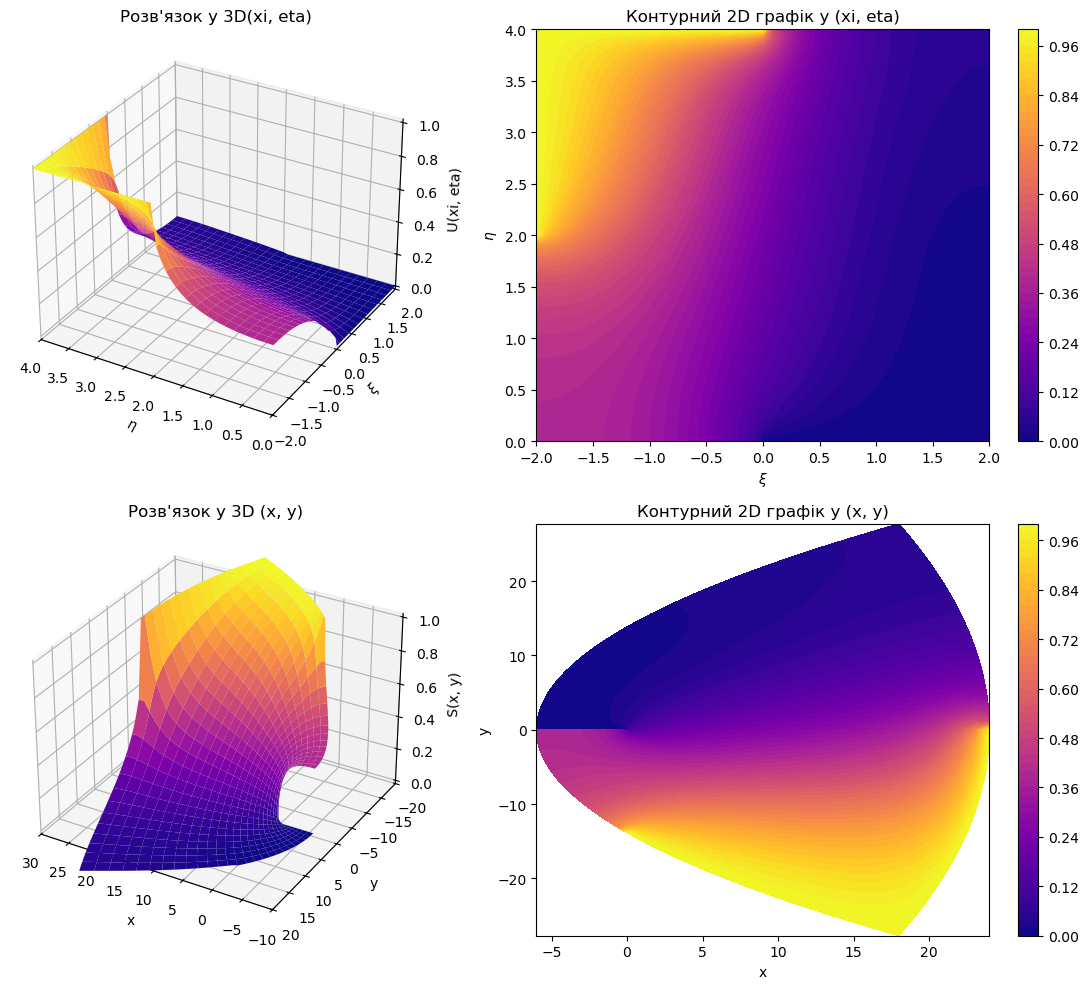

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import splu

# ---------------------------
# Параметри задачі, задання області та побудова сітки
# ---------------------------
a_coeff = 3.0
b_coeff = 4.0

xi_min, xi_max = -2.0, 2.0
eta_min, eta_max = 0.0, 4.0

Nx = 51
Ny = 51

dxi = (xi_max - xi_min) / (Nx - 1)
deta = (eta_max - eta_min) / (Ny - 1)

xi_vals = np.linspace(xi_min, xi_max, Nx)
eta_vals = np.linspace(eta_min, eta_max, Ny)

# ---------------------------
# Індекси для особливих граничних умов
# ---------------------------
j_split_2 = np.searchsorted(eta_vals, 2.0)
i_split_0 = np.searchsorted(xi_vals, 0.0)

def linear_index(i, j):
    return j + i * Ny

def build_system():
    """Побудова розрідженої системи рівнянь A*U = b."""
    A = lil_matrix((Nx * Ny, Nx * Ny))
    b = np.zeros(Nx * Ny)

    for i in range(Nx):
        xi = xi_vals[i]
        for j in range(Ny):
            eta = eta_vals[j]
            row = linear_index(i, j)

            # Перевірка граничних умов
            if i == 0:  # Ліва межа
                if j >= j_split_2:  # Діріхле
                    A[row, row] = 1.0
                    b[row] = 1.0
                else:  # Нейман
                    A[row, row] = 1.0
                    A[row, linear_index(1, j)] = -1.0
                continue

            if i == Nx - 1:  # Права межа
                if j < j_split_2:  # Діріхле
                    A[row, row] = 1.0
                    b[row] = 0.0
                else:  # Нейман
                    A[row, row] = 1.0
                    A[row, linear_index(Nx - 2, j)] = -1.0
                continue

            if j == Ny - 1:  # Верхня межа
                if i <= i_split_0:  # Діріхле
                    A[row, row] = 1.0
                    b[row] = 1.0
                else:  # Нейман
                    A[row, row] = 1.0
                    A[row, linear_index(i, Ny - 2)] = -1.0
                continue

            if j == 0:  # Нижня межа
                if i >= i_split_0:  # Діріхле
                    A[row, row] = 1.0
                    b[row] = 0.0
                else:  # Нейман
                    A[row, row] = 1.0
                    A[row, linear_index(i, 1)] = -1.0
                continue

            # Внутрішні точки
            c_im1j = 1.0 / (dxi**2) - (xi / (2 * dxi))
            c_ip1j = 1.0 / (dxi**2) + (xi / (2 * dxi))
            c_ijm1 = 1.0 / (deta**2) + (eta / (2 * deta))
            c_ijp1 = 1.0 / (deta**2) - (eta / (2 * deta))
            c_ij = -2.0 / (dxi**2) - 2.0 / (deta**2)

            A[row, linear_index(i, j)] = c_ij
            A[row, linear_index(i - 1, j)] = c_im1j
            A[row, linear_index(i + 1, j)] = c_ip1j
            A[row, linear_index(i, j - 1)] = c_ijm1
            A[row, linear_index(i, j + 1)] = c_ijp1
            b[row] = 0.0

    return A, b

def plot_results(U_matrix):
    """Візуалізація результатів."""
    XI, ETA = np.meshgrid(xi_vals, eta_vals)

    # Візуалізація у (xi, eta)
    fig = plt.figure(figsize=(12, 10))

    #3D поверхня
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax1.plot_surface(ETA, XI, U_matrix, cmap='plasma')
    ax1.set_xlabel(r'$\eta$')
    ax1.set_ylabel(r'$\xi$')
    ax1.set_zlabel('U(xi, eta)')
    ax1.set_xlim(4, 0)
    ax1.set_ylim(-2, 2)
    ax1.set_title('Розв\'язок у 3D(xi, eta)')

    #Контурний 2D графік
    ax2 = fig.add_subplot(2, 2, 2)
    contour = ax2.contourf(xi_vals, eta_vals, U_matrix, 50, cmap='plasma')
    ax2.set_xlabel(r'$\xi$')
    ax2.set_ylabel(r'$\eta$')
    ax2.set_title('Контурний 2D графік у (xi, eta)')
    fig.colorbar(contour, ax=ax2)

    # Перетворення в (x, y)
    X = (alpha / 2.0) * (ETA**2 - XI**2)
    Y = XI * ETA * np.sqrt(a_coeff * b_coeff)

    #3D поверхня
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    ax3.plot_surface(X, Y, U_matrix, cmap='plasma')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('S(x, y)')
    ax3.set_xlim(30, -10)
    ax3.set_ylim(20, -20)
    ax3.set_title('Розв\'язок у 3D (x, y)')

    #Контурний 2D графік
    ax4 = fig.add_subplot(2, 2, 4)
    contour_xy = ax4.contourf(X, Y, U_matrix, 50, cmap='plasma')
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    ax4.set_title('Контурний 2D графік у (x, y)')
    fig.colorbar(contour_xy, ax=ax4)

    plt.tight_layout()
    plt.show()

def main():
    # Побудова системи
    A, b = build_system()

    # Переводимо в формат CSC для splu
    A = A.tocsc()
    
    # Виконуємо LU-факторизацію та розв'язок
    A_lu = splu(A)
    U_flat = A_lu.solve(b)
    U_matrix = U_flat.reshape((Nx, Ny)).T #Не забути про транспонованість
    plot_results(U_matrix)

if __name__ == "__main__":
    main()